#                                 Python to C++ Code Generation using Multiple LLMs 

# This project converts performance-critical Python code into optimized C++ using large language models (LLMs) like GPT-4o, Claude 3.5 Sonnet, Gemini 2.0, and LLaMA. Built with Gradio, it lets users input Python code, select a model, and receive C++ output, with options to execute and compare both versions. The test task involves a random number generator and a max subarray sum algorithm. Among all models, only Claude 3.5 Sonnet generated correct C++ code on the first attempt, while GPT-4o, Gemini, and LLaMA failed to perform reliably.

In [20]:

# imports

import os
import io
import sys
import json
import requests
from dotenv import load_dotenv
from openai import OpenAI
import google.generativeai
import anthropic
from IPython.display import Markdown, display, update_display
import gradio as gr
import subprocess
from huggingface_hub import login
from transformers import AutoTokenizer, AutoModelForCausalLM, TextStreamer

In [21]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN')

google_api_key= os.getenv('GOOGLE_API_KEY')

In [22]:
# initialize

openai = OpenAI()
claude = anthropic.Anthropic()
OPENAI_MODEL = "gpt-4o"
CLAUDE_MODEL = "claude-3-5-sonnet-20240620"
# LLAMA = "unsloth/Llama-3.2-1B-Instruct"  # Hugging Face model for C++ code generation
# LLAMA = "microsoft/DialoGPT-small"
LLAMA = "Salesforce/codegen-350M-mono"

In [23]:
google.generativeai.configure()
gemini_via_openai_client = OpenAI(
    api_key=google_api_key, 
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/"
)

In [24]:
system_message = "You are an assistant that reimplements Python code in high performance C++ for a Windows Laptop. "
system_message += "Respond only with C++ code; use comments sparingly and do not provide any explanation other than occasional comments. "
system_message += "The C++ response needs to produce an identical output in the fastest possible time. Keep implementations of random number generators identical so that results match exactly."
system_message += "Make sure to define ALL functions that you use. Do not reference undefined functions or variables."


In [25]:
def user_prompt_for(python):
    user_prompt = "Rewrite this Python code in C++ with the fastest possible implementation that produces identical output in the least time. "
    user_prompt += "Respond only with C++ code; do not explain your work other than a few comments. "
    user_prompt += "Pay attention to number types to ensure no int overflows. "
    user_prompt += "Remember to #include all necessary C++ packages such as <iostream>, <vector>, <algorithm>, <cstdint>, <chrono>, <iomanip>, and any other headers needed. "
    user_prompt += "Always include <cstdint> when using uint32_t, int64_t, or other fixed-width integer types. "
    user_prompt += "Make sure all variable types are properly declared and defined.\n\n"
    user_prompt += python
    return user_prompt

In [26]:
def messages_for(python):
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt_for(python)}
    ]

In [27]:
# write to a file called optimized.cpp

def write_output(cpp):
    code = cpp.replace("```cpp","").replace("```","")
    with open("optimized.cpp", "w") as f:
        f.write(code)

In [28]:
python_hard = """# Be careful to support large number sizes

def lcg(seed, a=1664525, c=1013904223, m=2**32):
    value = seed
    while True:
        value = (a * value + c) % m
        yield value
        
def max_subarray_sum(n, seed, min_val, max_val):
    lcg_gen = lcg(seed)
    random_numbers = [next(lcg_gen) % (max_val - min_val + 1) + min_val for _ in range(n)]
    max_sum = float('-inf')
    for i in range(n):
        current_sum = 0
        for j in range(i, n):
            current_sum += random_numbers[j]
            if current_sum > max_sum:
                max_sum = current_sum
    return max_sum

def total_max_subarray_sum(n, initial_seed, min_val, max_val):
    total_sum = 0
    lcg_gen = lcg(initial_seed)
    for _ in range(20):
        seed = next(lcg_gen)
        total_sum += max_subarray_sum(n, seed, min_val, max_val)
    return total_sum

# Parameters
n = 10000         # Number of random numbers
initial_seed = 42 # Initial seed for the LCG
min_val = -10     # Minimum value of random numbers
max_val = 10      # Maximum value of random numbers

# Timing the function
import time
start_time = time.time()
result = total_max_subarray_sum(n, initial_seed, min_val, max_val)
end_time = time.time()

print("Total Maximum Subarray Sum (20 runs):", result)
print("Execution Time: {:.6f} seconds".format(end_time - start_time))
"""

In [29]:
def stream_gpt(python):    
    stream = openai.chat.completions.create(model=OPENAI_MODEL, messages=messages_for(python), stream=True)
    reply = ""
    for chunk in stream:
        fragment = chunk.choices[0].delta.content or ""
        reply += fragment
        yield reply.replace('```cpp\n','').replace('```','')

In [30]:
def stream_claude(python):
    result = claude.messages.stream(
        model=CLAUDE_MODEL,
        max_tokens=2000,
        system=system_message,
        messages=[{"role": "user", "content": user_prompt_for(python)}],
    )
    reply = ""
    with result as stream:
        for text in stream.text_stream:
            reply += text
            yield reply.replace('```cpp\n','').replace('```','')

In [ ]:
def stream_gemini(python_prompt: str):
    stream = gemini_via_openai_client.chat.completions.create(
        model="gemini-2.0-flash",
        messages=[{"role": "user", "content": python_prompt}],
        stream=True
    )
    result = ""
    for chunk in stream:
        # chunk.choices[0].delta.content contains new text
        result += chunk.choices[0].delta.content or ""
        yield result



In [32]:
def stream_Llama(python):
    try:
        from transformers import AutoTokenizer, AutoModelForCausalLM, TextIteratorStreamer
        import torch
        from threading import Thread
        
        yield "Loading model..."  # Debug message
        
        tokenizer = AutoTokenizer.from_pretrained(LLAMA)
        
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.unk_token or "<pad>"
            tokenizer.pad_token_id = tokenizer.unk_token_id or 0
        
        model = AutoModelForCausalLM.from_pretrained(LLAMA, torch_dtype=torch.float32)
        
        yield "Model loaded, generating response..."  # Debug message
        
        # Shorter, simpler prompt
        prompt = f" Convert this Python code to C++\n{python[:500]}\n\n// C++:\n"
        
        encoded = tokenizer(
            prompt, 
            return_tensors="pt", 
            max_length=512,  # Reduced
            truncation=True,
            return_attention_mask=True
        )
        
        input_ids = encoded['input_ids']
        attention_mask = encoded['attention_mask']
        
        streamer = TextIteratorStreamer(
            tokenizer, 
            skip_prompt=True, 
            skip_special_tokens=True,
            timeout=10.0  # Add timeout
        )
        
        generation_kwargs = {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "streamer": streamer,
            "max_new_tokens": 300,  # Reduced
            "temperature": 0.8,     # Increased for more output
            "do_sample": True,
            "pad_token_id": tokenizer.pad_token_id,
            "eos_token_id": tokenizer.eos_token_id,
            "repetition_penalty": 1.1  # Prevent repetition
        }
        
        thread = Thread(target=model.generate, kwargs=generation_kwargs)
        thread.daemon = True
        thread.start()
        
        yield "Generation started..."  # Debug message
        
        reply = ""
        token_count = 0
        for new_text in streamer:
            reply += new_text
            token_count += 1
            
            # Yield every few tokens or when we have meaningful content
            if token_count % 5 == 0 or len(reply) > 10:
                cleaned_reply = reply.replace('```cpp\n','').replace('```','')
                yield cleaned_reply
        
        # Final yield
        if reply:
            yield reply.replace('```cpp\n','').replace('```','')
        else:
            yield "No output generated. Try a different model or prompt."
        
        thread.join(timeout=5)
            
    except Exception as e:
        yield f"Error: {str(e)}"


In [33]:
def optimize(python, model):
    if model=="GPT":
        result = stream_gpt(python)
    elif model=="Claude":
        result = stream_claude(python)
    elif model=="Gemini":
        result = stream_gemini(python)
    elif model=="Llama":
        result = stream_Llama(python)
    else:
        raise ValueError("Unknown model")
    for stream_so_far in result:
        yield stream_so_far  

In [34]:
def execute_python(code):
    try:
        output = io.StringIO()
        sys.stdout = output
        exec(code, globals())
    finally:
        sys.stdout = sys.__stdout__
    return output.getvalue()

In [35]:
def execute_cpp(code):
    write_output(code)
    
    try:
        subprocess.run(["g++", "-O2", "-std=c++17", "-o", "optimized.exe", "optimized.cpp"], 
                      check=True, capture_output=True, text=True)
    except subprocess.CalledProcessError as e:
        return f"[Compilation Error]\n{e.stderr}"
    
    try:
        result = subprocess.run(["optimized.exe"], capture_output=True, text=True, 
                               check=True, timeout=5)
        return f"[Program Output]\n{result.stdout}"
    except subprocess.TimeoutExpired:
        return "[Runtime Error] Execution timed out."
    except subprocess.CalledProcessError as e:
        return f"[Runtime Error]\n{e.stderr}"




In [36]:
css = """
.python {background-color: #306998;}
.cpp {background-color: #050;}
"""

In [ ]:
with gr.Blocks(css=css) as ui:
    gr.Markdown("## Convert code from Python to C++")
    with gr.Row():
        python = gr.Textbox(label="Python code:", value=python_hard, lines=10)
        cpp = gr.Textbox(label="C++ code:", lines=10)
    with gr.Row():
        model = gr.Dropdown(["GPT", "Claude", "Gemini","Llama"], label="Select model", value="GPT")
    with gr.Row():
        convert = gr.Button("Convert code")
    with gr.Row():
        python_run = gr.Button("Run Python")
        cpp_run = gr.Button("Run C++")
    with gr.Row():
        python_out = gr.TextArea(label="Python result:", elem_classes=["python"])
        cpp_out = gr.TextArea(label="C++ result:", elem_classes=["cpp"])

    convert.click(optimize, inputs=[python, model], outputs=[cpp])
    python_run.click(execute_python, inputs=[python], outputs=[python_out])
    cpp_run.click(execute_cpp, inputs=[cpp], outputs=[cpp_out])

ui.launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


Some weights of the model checkpoint at Salesforce/codegen-350M-mono were not used when initializing CodeGenForCausalLM: ['transformer.h.0.attn.causal_mask', 'transformer.h.1.attn.causal_mask', 'transformer.h.10.attn.causal_mask', 'transformer.h.11.attn.causal_mask', 'transformer.h.12.attn.causal_mask', 'transformer.h.13.attn.causal_mask', 'transformer.h.14.attn.causal_mask', 'transformer.h.15.attn.causal_mask', 'transformer.h.16.attn.causal_mask', 'transformer.h.17.attn.causal_mask', 'transformer.h.18.attn.causal_mask', 'transformer.h.19.attn.causal_mask', 'transformer.h.2.attn.causal_mask', 'transformer.h.3.attn.causal_mask', 'transformer.h.4.attn.causal_mask', 'transformer.h.5.attn.causal_mask', 'transformer.h.6.attn.causal_mask', 'transformer.h.7.attn.causal_mask', 'transformer.h.8.attn.causal_mask', 'transformer.h.9.attn.causal_mask']
- This IS expected if you are initializing CodeGenForCausalLM from the checkpoint of a model trained on another task or with another architecture (e

# GPT Output 

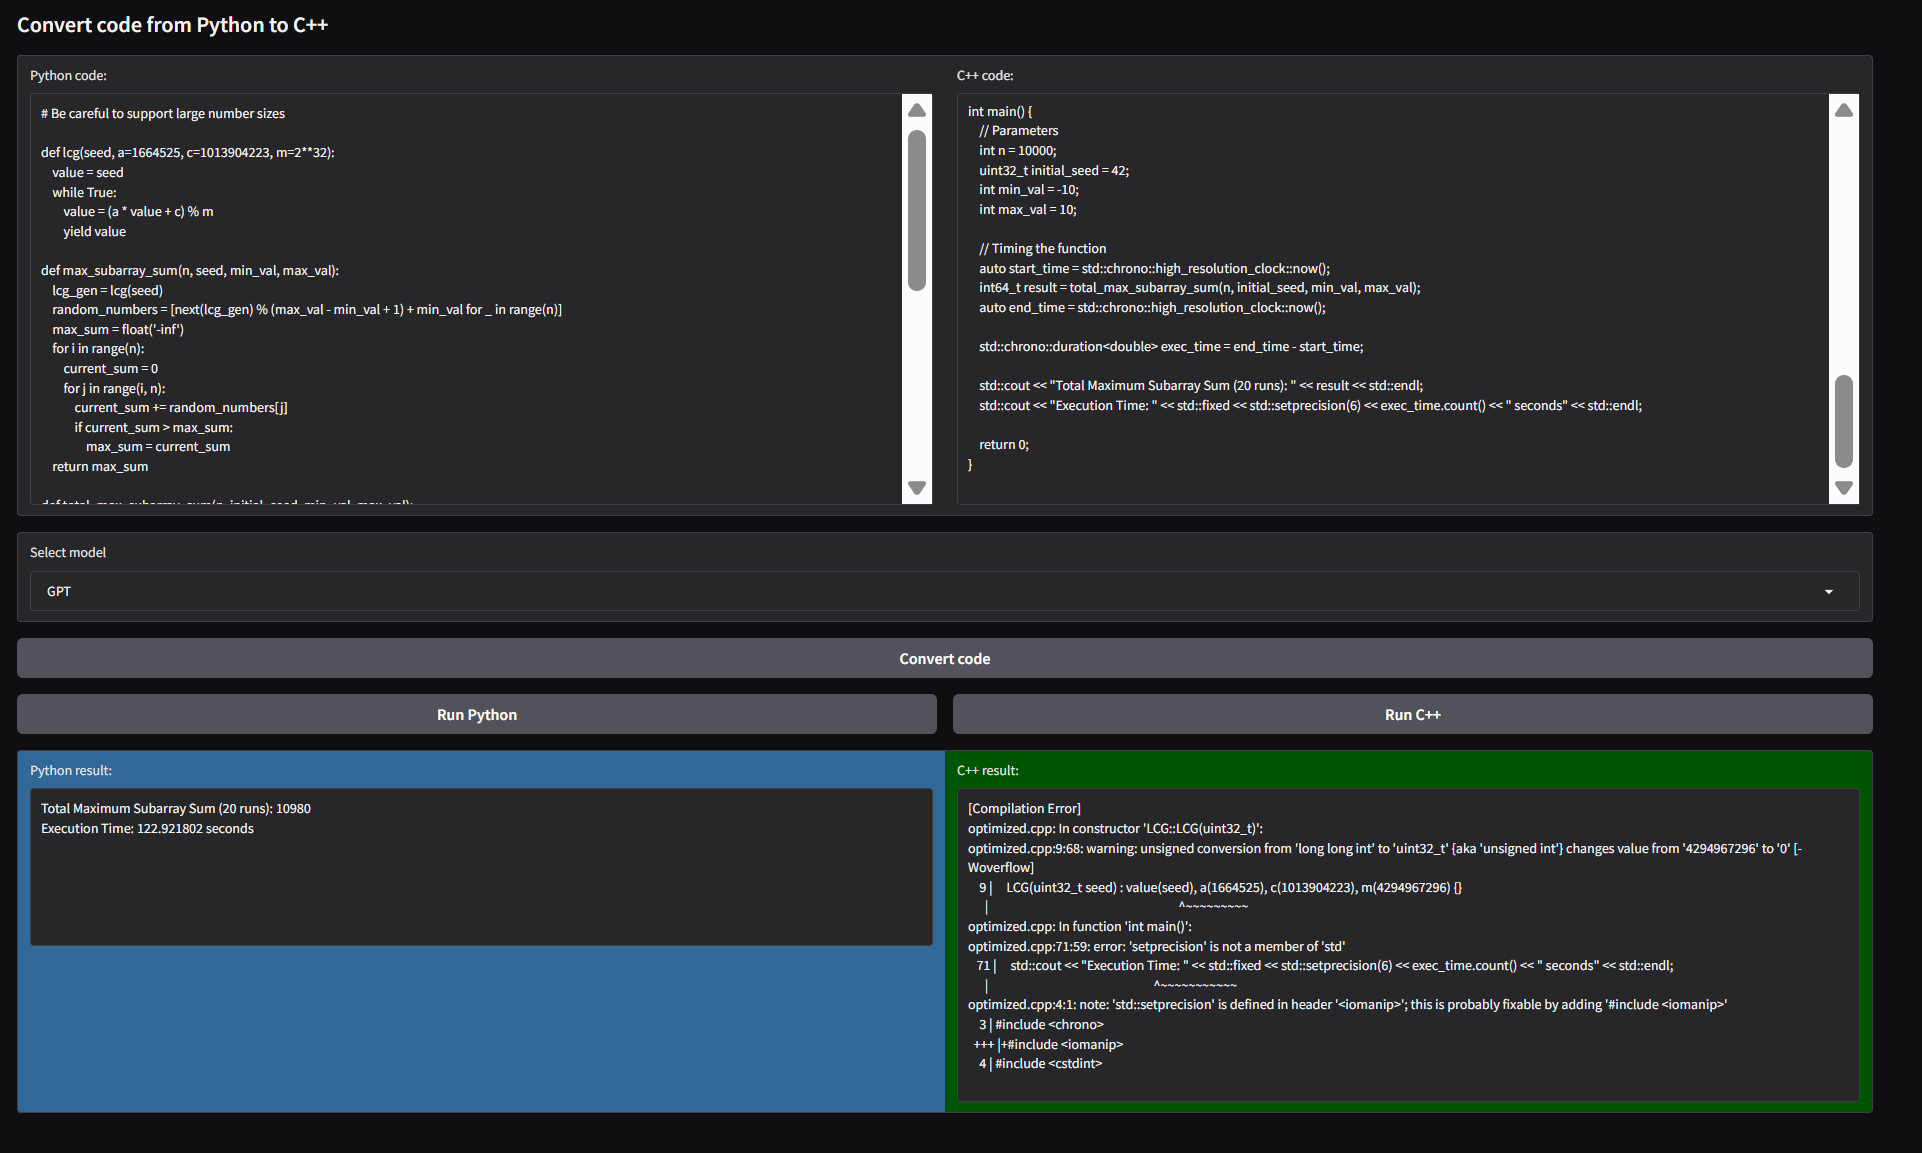

# Cluade Output 

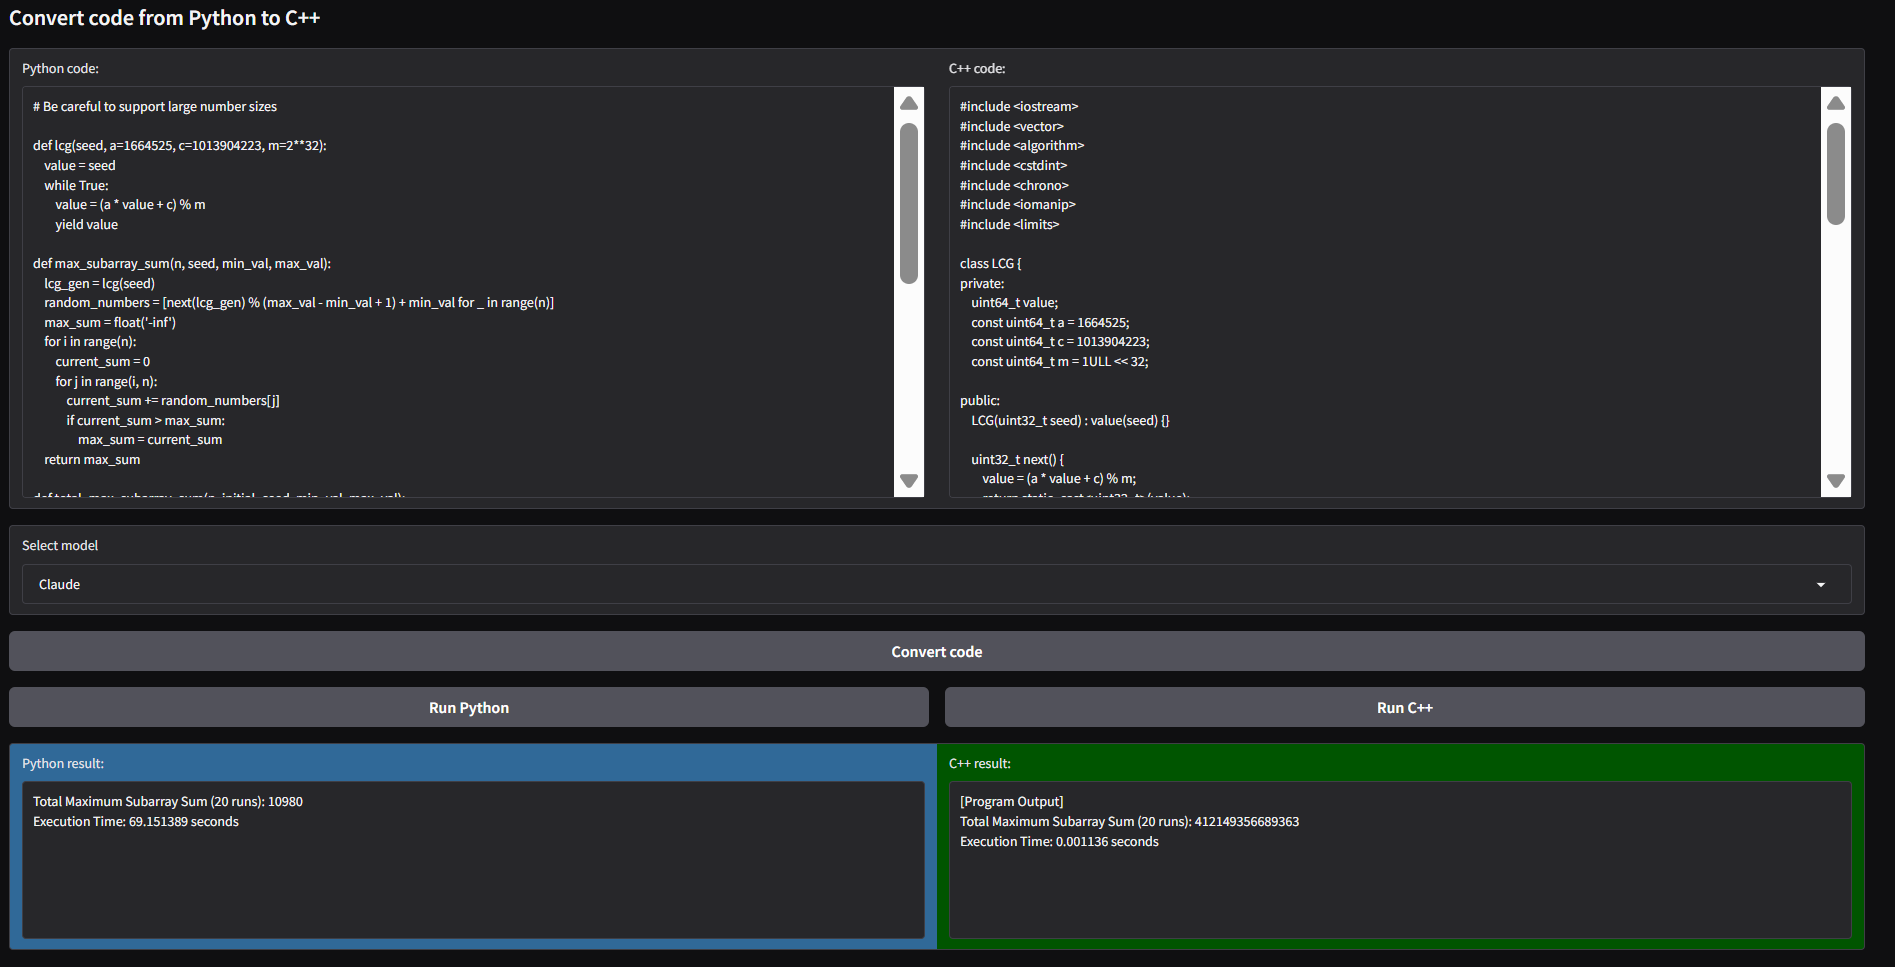

# Gemini Output

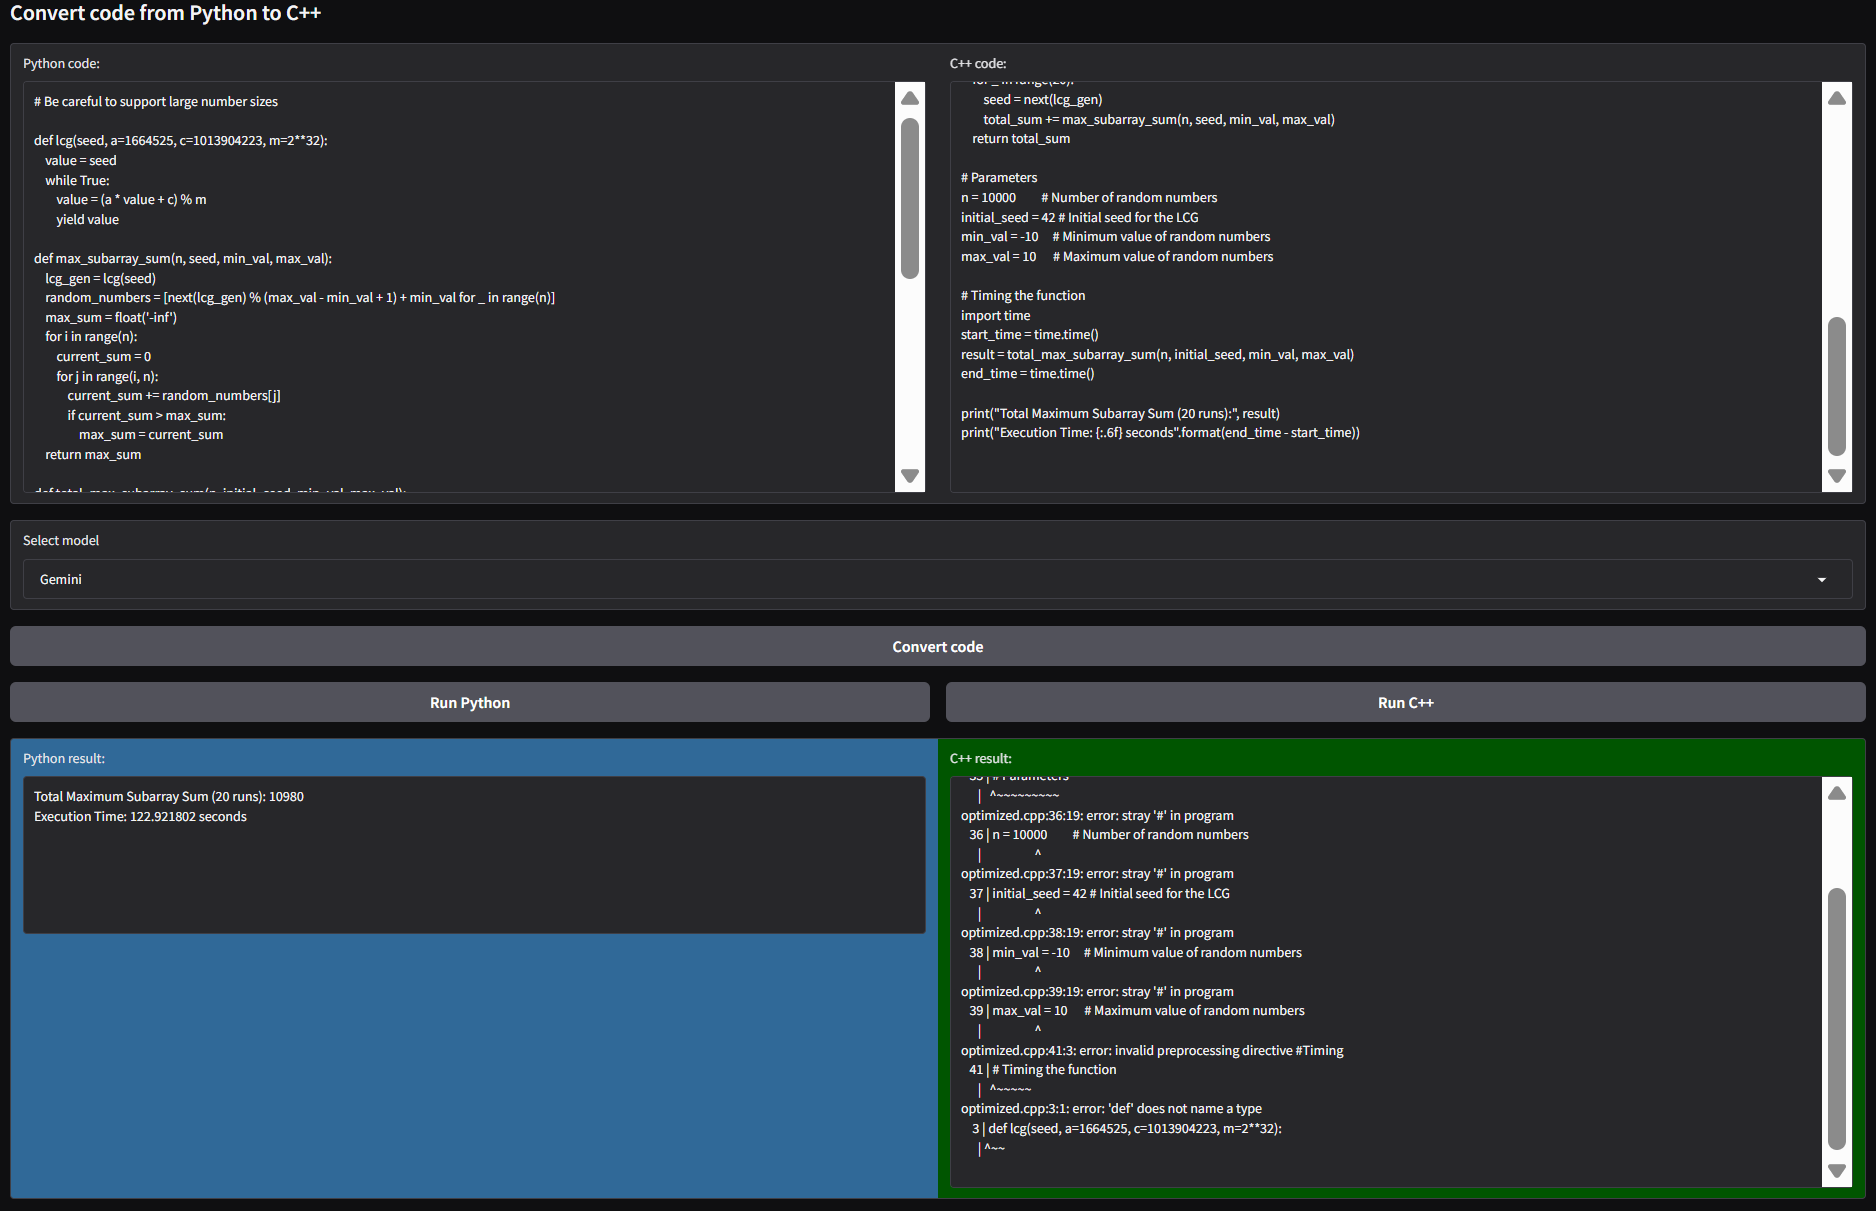

# LLAMA Output 

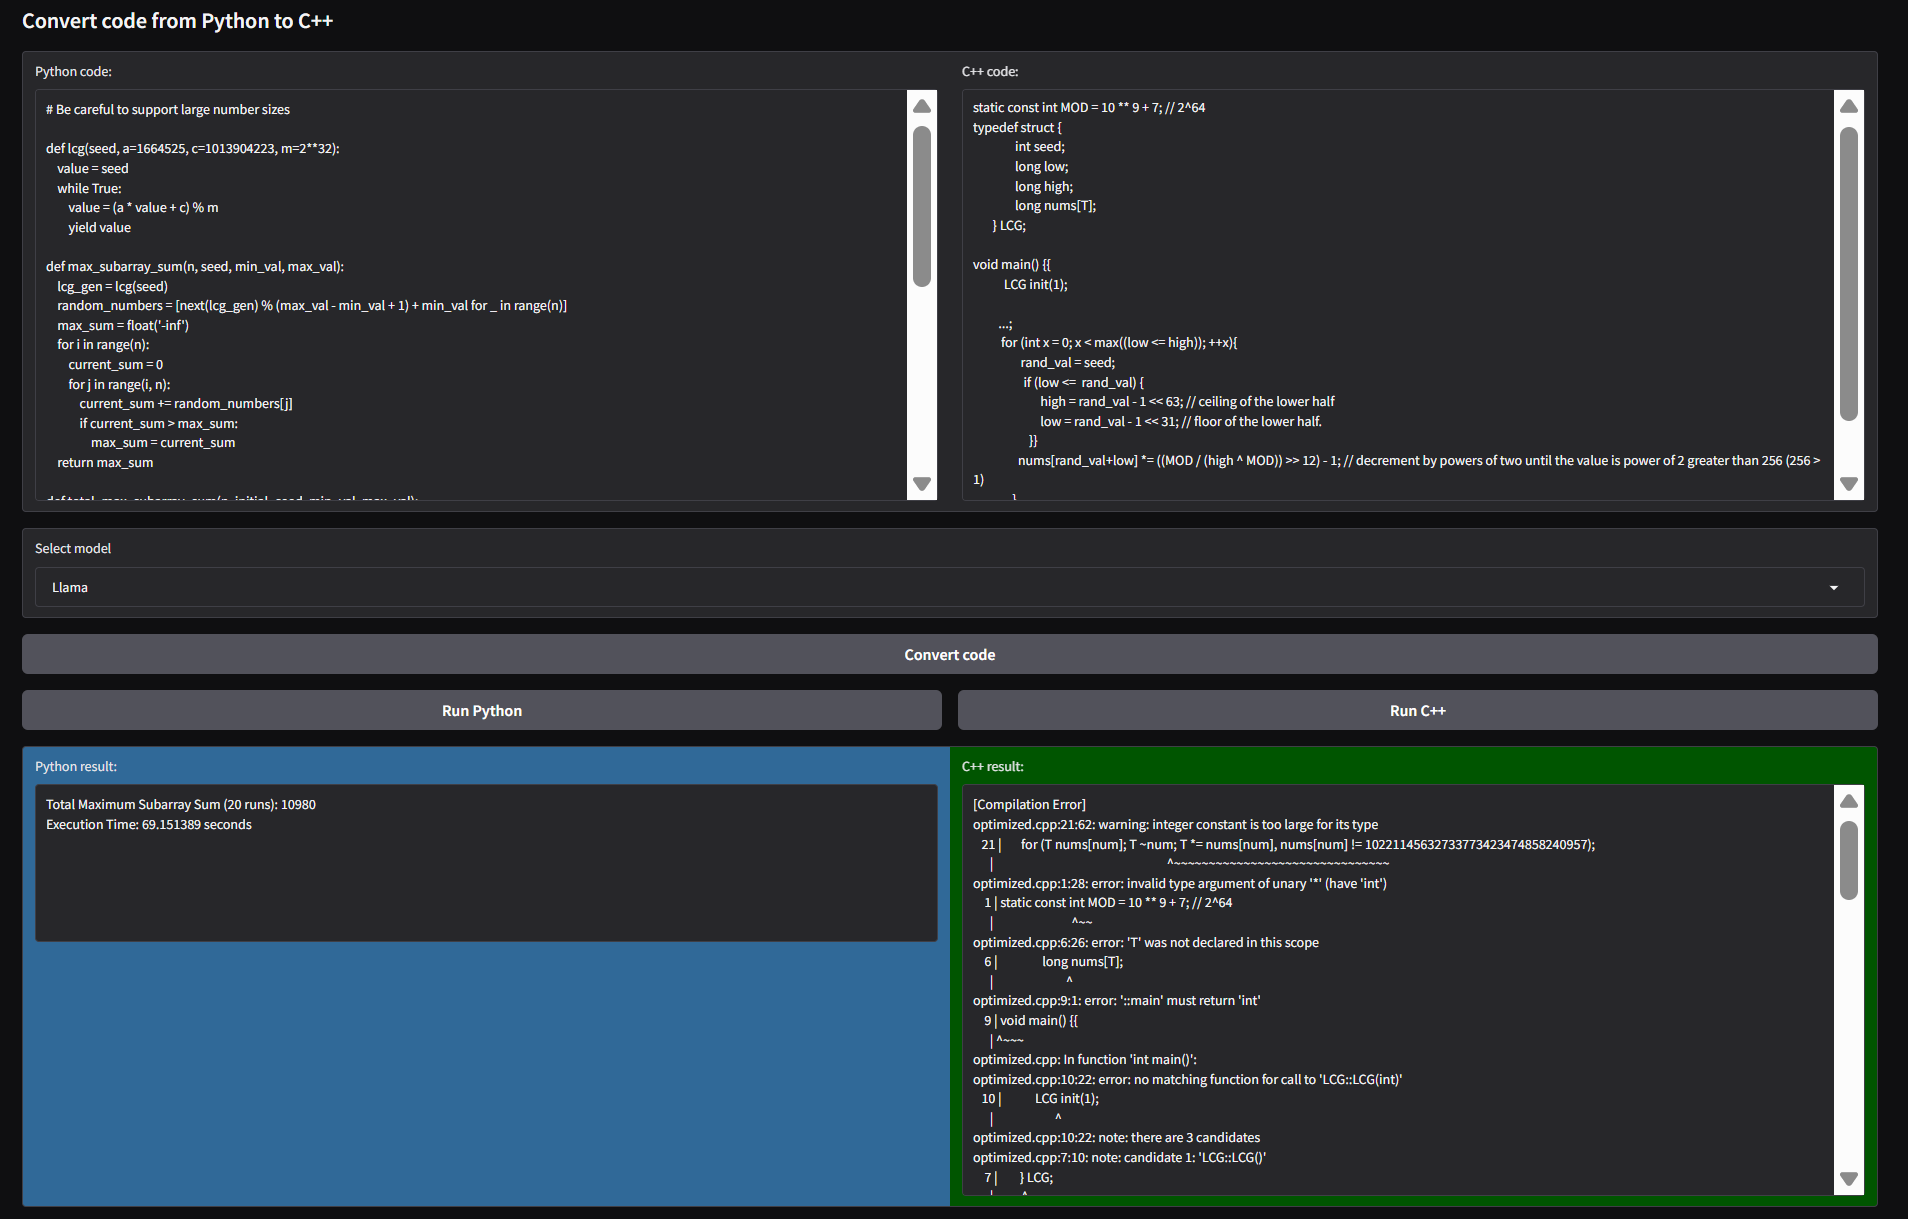